<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/model/dense_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyDrive
!mkdir work_dir
!pip install -q -U keras-tuner

     |████████████████████████████████| 61kB 7.9MB/s 


# DEFINE

In [ ]:
DATA_PATH                           = '/content/work_dir'
RANDOM_SEED                         = 42

# IMPORT

In [ ]:
# Data access
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# General
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import sys
import PIL
import cv2
import re
import IPython
from tqdm.notebook import tqdm

# ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import lognorm
from scipy.stats import shapiro
from sklearn.model_selection import StratifiedKFold, KFold

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
import kerastuner as kt

# DOWNLOAD DATA

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download clear_train.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1-3kiZxEddvuNFoRTfMA6cA8bu7LjP2b3"}) # откуда берем файл
downloaded.GetContentFile(DATA_PATH+'/clear_train.csv') # куда сохраняем файл в вирутальной машине колаба

# Download clear_test.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1-0yG59TcpJoDSeOclid1z-nc1Fh3yud2"})
downloaded.GetContentFile(DATA_PATH+'/clear_test.csv')

# Download sample_submission from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1Edwuioev6uEyeXuCQuloPNQ70V5-3HZG"})
downloaded.GetContentFile(DATA_PATH+'/sample_submission.csv')

In [ ]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')
sample_submission = pd.read_csv(DATA_PATH+'/sample_submission.csv')

# PREPARING

In [ ]:
df = pd.concat([train, test])

(array([  73.,  310., 1460., 2195., 2075.,  600., 1091.,  449.,    0.,
         100.]),
 array([14183.43949584, 14183.82060695, 14184.20171807, 14184.58282919,
        14184.96394031, 14185.34505142, 14185.72616254, 14186.10727366,
        14186.48838478, 14186.8694959 , 14187.25060701]),
 <a list of 10 Patch objects>)

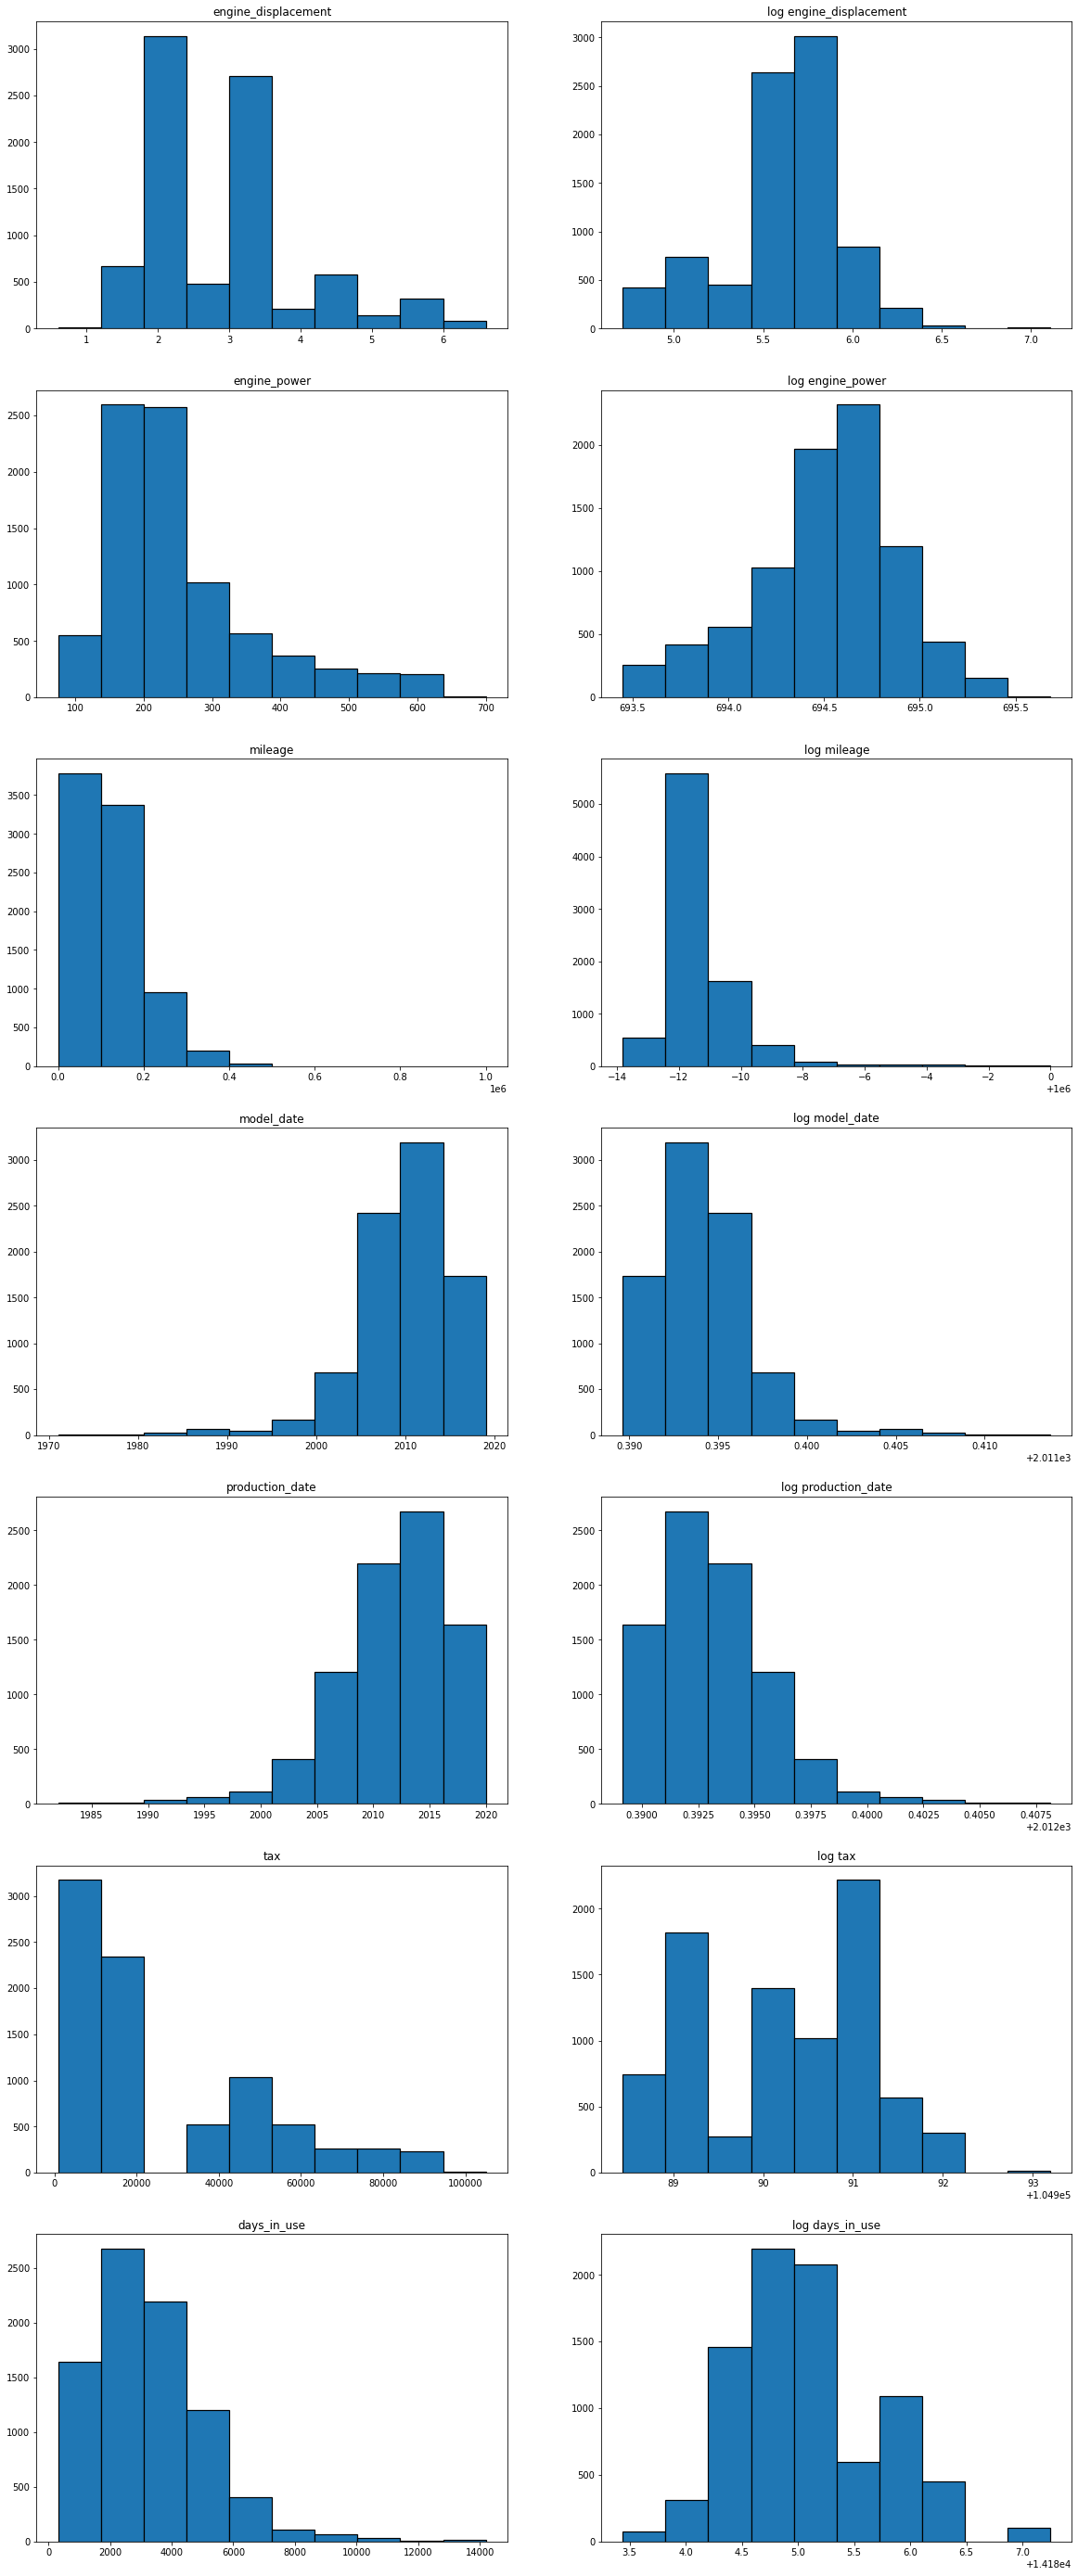

In [ ]:
fig, ax = plt.subplots(7,2, figsize=(20,50))

# ####################### engine_displacement ############################
ax[0,0].set_title('engine_displacement')
ax[0,0].hist(df['engine_displacement'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[0,1].set_title('log engine_displacement')
ax[0,1].hist(df['engine_displacement'].max() - np.log(df['engine_displacement']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### engine_power ############################
ax[1,0].set_title('engine_power')
ax[1,0].hist(df['engine_power'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[1,1].set_title('log engine_power')
ax[1,1].hist(df['engine_power'].max() - np.log(df['engine_power']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### mileage ############################
ax[2,0].set_title('mileage')
ax[2,0].hist(df['mileage'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[2,1].set_title('log mileage')
ax[2,1].hist(df['mileage'].max() - np.log(df['mileage']), bins=10, edgecolor='black' ,linewidth=1.2)


# ####################### model_date ############################
ax[3,0].set_title('model_date')
ax[3,0].hist(df['model_date'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[3,1].set_title('log model_date')
ax[3,1].hist(df['model_date'].max() - np.log(df['model_date']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### production_date ############################
ax[4,0].set_title('production_date')
ax[4,0].hist(df['production_date'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[4,1].set_title('log production_date')
ax[4,1].hist(df['production_date'].max() - np.log(df['production_date']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### tax ############################
ax[5,0].set_title('tax')
ax[5,0].hist(df['tax'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[5,1].set_title('log tax')
ax[5,1].hist(df['tax'].max() - np.log(df['tax']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### days_in_use ############################
ax[6,0].set_title('days_in_use')
ax[6,0].hist(df['days_in_use'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[6,1].set_title('log days_in_use')
ax[6,1].hist(df['days_in_use'].max() - np.log(df['days_in_use']), bins=10, edgecolor='black' ,linewidth=1.2)

In [ ]:
df.price.fillna(0, inplace=True)
df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

In [ ]:
# ##################### Логорифмируем ######################
df.engine_displacement = df.engine_displacement.max() - np.log(df.engine_displacement)
df.engine_power = df.engine_power.max() - np.log(df.engine_power)
# df.mileage = df.mileage.max() - np.log(df.mileage)
# df.model_date = df.model_date.max() - np.log(df.model_date)
# df.production_date = df.production_date.max() - np.log(df.production_date)
# df.num_of_doors = np.log(df.num_of_doors)
# df.tax = np.log(df.tax)
# df.days_in_use = df.days_in_use.max() - np.log(df.days_in_use)

Модель показывает лучше результат, если признак **num_of_doors** сделать категориальным.

Если взять логорифм перед нормализацией от всех признаков, кроме **mileage**, то модель показывает лучший результат

In [ ]:
def data_prep(df):

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################## Label Encoding #####################################
  for column in categorical_features:
      df[column] = df[column].astype('category').cat.codes
  
  # ############################### One Hot encoding ###################################
  df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df

In [ ]:
df = data_prep(df)
df.shape

(8353, 546)

# SPLIT

In [ ]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample', 'sell_id'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['description', 'price', 'sample', 'sell_id'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

В результате многих опытов выяснил, что наилучший результат модель показывает, когда на валидационную выборку выделено наименьшее количество данных. Если я правильно понимаю это связано с тем, что я выделаю больше данных для обучения. Отсюда можно сделать логичный вывод, что имея в целом больше данных модель будет выдавать результат лучше.

# MODEL

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
def build_model(LR, EPOCHS, OPTIMIZER_TYPE):

  # ######################### Create simple neural network #############################
  model = Sequential()
  model.add(L.Dense(1090, input_dim=X_train.shape[1], activation="relu", name='dense_1090'))
  model.add(L.Dropout(0.85))
  model.add(L.Dense(545, activation="relu", name='dense_545'))
  model.add(L.Dense(1, activation="linear", name='output_dense_1'))

  display(model.summary())

  plt.figure(figsize=(20,15))
  plot_model(model, to_file=DATA_PATH+'/model_plot.png', show_shapes=True, show_layer_names=True)
  img = mpimg.imread(DATA_PATH+'/model_plot.png')
  plt.imshow(img)
  plt.show()

  # ######################### Optimizer ##############################
  if OPTIMIZER_TYPE == 'Adam':
    optimizer = tf.keras.optimizers.Adam(LR)
  elif OPTIMIZER_TYPE == 'Adamax':
    optimizer = tf.keras.optimizers.Adamax(LR)

  model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

  # ######################## Checkpoints #############################
  checkpoint = ModelCheckpoint(DATA_PATH+'/best_model.hdf5' , monitor='val_MAPE', verbose=0  , mode='min', save_best_only=True)
  earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
  callbacks_list = [checkpoint, earlystop]

  # ######################## Fit model ##############################
  history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )
  
  # ######################## Saving best model #####################
  model.load_weights(DATA_PATH+'/best_model.hdf5')
  model.save(DATA_PATH+'/nn_1.hdf5')

  # ######################## Show results ###########################
  plt.figure(figsize=(15,10))
  plt.title('Loss')
  plt.plot(history.history['MAPE'], label='train')
  plt.plot(history.history['val_MAPE'], label='test')
  plt.legend()
  plt.grid()
  plt.show()

  test_predict_nn1 = model.predict(X_test)
  print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

  return model, checkpoint, earlystop, callbacks_list, history, test_predict_nn1

Опытным путем установил, что лучший результат модель показывает, когда мы используем **Adamax optimizer** с **learning rate 0.1**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1090 (Dense)           (None, 1090)              591870    
_________________________________________________________________
dropout (Dropout)            (None, 1090)              0         
_________________________________________________________________
dense_545 (Dense)            (None, 545)               594595    
_________________________________________________________________
output_dense_1 (Dense)       (None, 1)                 546       
Total params: 1,187,011
Trainable params: 1,187,011
Non-trainable params: 0
_________________________________________________________________


None

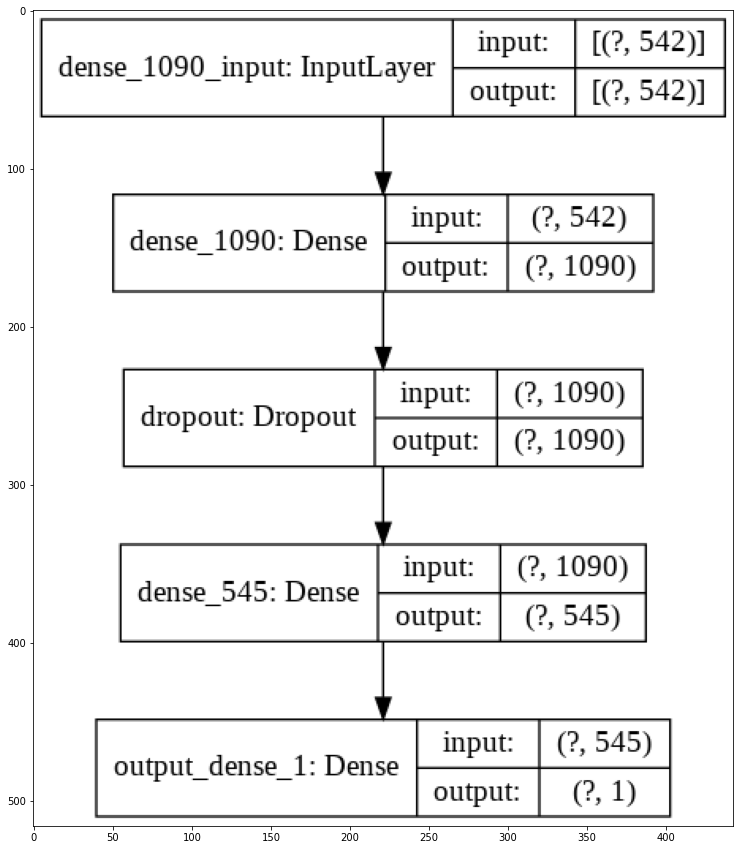

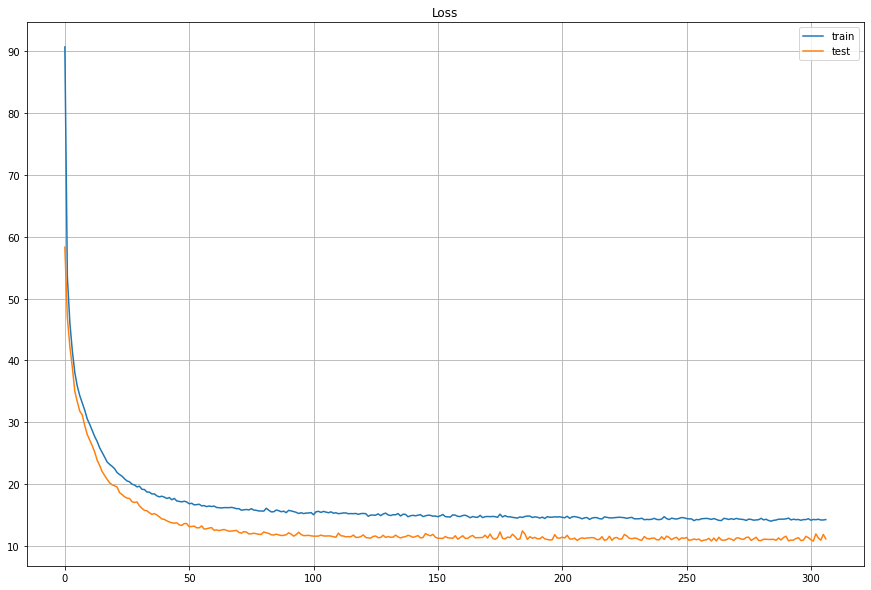

TEST mape: 10.79%


In [ ]:
model, checkpoint, earlystop, callbacks_list, history, test_predict_nn1 = build_model(LR=0.1, EPOCHS=2000, OPTIMIZER_TYPE='Adamax')

По графику получаеться, на валидационной выборке результат лучше, чем на тренировочной. Поискал в интеренете информацию по этому поводу. Кто-то говорит, что это overfitting (переобучение). Кто-то говорит, что это может быть связанно с тем, что в валидационную выборку попадают более простые данные, на которых лечге удается предсказать таргет. На данный момент, при таком графике результат на кагле получаеться самый высокий.

# PREDICT

In [ ]:
predict_submission = model.predict(test)

sample_submission['price'] = predict_submission
sample_submission.to_csv(DATA_PATH+f'/sub_nn_{round((mape(y_test, test_predict_nn1[:,0])*100),2)}.csv'.replace('.', '_', 1), index=False)
display(sample_submission.head(10))

,sell_id,price
0,1099427284,5.015192e+05
1,1096405886,2.518199e+06
2,1100195294,6.456681e+05
3,1099827282,4.857544e+05
4,1100076198,2.710193e+06
5,1090159352,3.161068e+06
6,1098987386,1.575680e+06
7,1098639040,1.554986e+06
8,1099933039,1.088622e+06
9,1099565572,5.220434e+05


# CROSS_VALIDATION

In [ ]:
cv_submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) 
score_ls = []
splits = list(KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED).split(X, y))

def simple_nn_model_cv(X_train, y_train, X_test, y_test):

  model = Sequential()
  model.add(L.Dense(1090, input_dim=X_train.shape[1], activation="relu", name='dense_1090'))
  model.add(L.Dropout(0.85))
  model.add(L.Dense(545, activation="relu", name='dense_545'))
  model.add(L.Dense(1, activation="linear", name='output_dense_1'))

  # ######################### Optimizer ##############################
  optimizer = tf.keras.optimizers.Adamax(0.1)
  model.compile(loss='MAPE',optimizer=optimizer, metrics='MAPE')

  # ######################## Checkpoints #############################
  checkpoint = ModelCheckpoint(DATA_PATH+'/best_model.hdf5' , monitor='val_MAPE', verbose=0  , mode='min', save_best_only=True)
  earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
  callbacks_list = [checkpoint, earlystop]

  # ######################## Fit model ##############################
  history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=2000, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )
  
  # ######################## Saving best model #####################
  model.load_weights(DATA_PATH+'/best_model.hdf5')
  model.save(DATA_PATH+'/nn_1.hdf5')

  return model

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=10,):

  X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]

  model = simple_nn_model_cv(X_train, y_train, X_test, y_test,)

  test_predict_nn1 = model.predict(X_test)
  test_score = mape(y_test, test_predict_nn1)
  score_ls.append(test_score)
  print(f"{idx+1} Fold TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

  cv_submissions[f'sub_{idx+1}'] = model.predict(test)

print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold TEST mape: 10.78%
2 Fold TEST mape: 12.24%
3 Fold TEST mape: 11.43%
4 Fold TEST mape: 11.68%
5 Fold TEST mape: 11.55%
6 Fold TEST mape: 11.37%
7 Fold TEST mape: 10.81%
8 Fold TEST mape: 11.72%
9 Fold TEST mape: 11.78%
10 Fold TEST mape: 12.12%

Mean Score: 1.140
Std Score: 0.0545
Max Score: 1.212
Min Score: 1.044


In [ ]:
cv_submissions.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,sub_10
0,5.008752e+05,5.400529e+05,4.929893e+05,5.079183e+05,4.780343e+05,4.749035e+05,4.977776e+05,4.144970e+05,4.575365e+05,4.737672e+05
1,2.604857e+06,2.605712e+06,2.541696e+06,2.581884e+06,2.635609e+06,2.661525e+06,2.613134e+06,2.661556e+06,2.627521e+06,2.734321e+06
2,6.358641e+05,6.526329e+05,6.193584e+05,6.267315e+05,6.613225e+05,6.335756e+05,6.292543e+05,6.608635e+05,6.096187e+05,6.357407e+05
3,4.997812e+05,4.858141e+05,4.817742e+05,4.750112e+05,4.980654e+05,4.800856e+05,4.915261e+05,4.882602e+05,5.054978e+05,5.031495e+05
4,2.721381e+06,2.767806e+06,2.666969e+06,2.655873e+06,2.657296e+06,2.729294e+06,2.698925e+06,2.723222e+06,2.661469e+06,2.731892e+06
5,3.193220e+06,2.981394e+06,3.204196e+06,3.043589e+06,3.154887e+06,3.112858e+06,3.228454e+06,3.209616e+06,3.146661e+06,3.301896e+06
6,1.595824e+06,1.575744e+06,1.627567e+06,1.586306e+06,1.611873e+06,1.615439e+06,1.596386e+06,1.675651e+06,1.601078e+06,1.581429e+06
7,1.586164e+06,1.535912e+06,1.530806e+06,1.467800e+06,1.534426e+06,1.490339e+06,1.530812e+06,1.511250e+06,1.550973e+06,1.552302e+06
8,1.116471e+06,1.087739e+06,1.074054e+06,1.052096e+06,1.099740e+06,1.072499e+06,1.079771e+06,1.061774e+06,1.064769e+06,1.031806e+06
9,5.151163e+05,5.053278e+05,5.048846e+05,5.051369e+05,5.391494e+05,5.017107e+05,5.083338e+05,5.047395e+05,5.232642e+05,5.347367e+05


In [ ]:
sample_submission['price'] = (cv_submissions.sum(axis=1)/len(cv_submissions.columns))
sample_submission.to_csv(DATA_PATH+'/sub_nn_cv.csv', index=False)
display(sample_submission.head(10))

,sell_id,price
0,1099427284,4.838352e+05
1,1096405886,2.626782e+06
2,1100195294,6.364962e+05
3,1099827282,4.908966e+05
4,1100076198,2.701413e+06
5,1090159352,3.157677e+06
6,1098987386,1.606730e+06
7,1098639040,1.529078e+06
8,1099933039,1.074072e+06
9,1099565572,5.142399e+05
